In [47]:
import numpy as np
import pandas as pd
import multiprocessing as mp
import matplotlib.pyplot as plt

from numba import njit
from itertools import product
from scipy.sparse.linalg import norm

In [43]:
def e(i, d):
    ei = np.zeros(d)
    ei[i] = 1
    return ei



def KWSA(F, w, m, c, d):
    """ 
    Kiefer-Wolfowitz stochastic approximation
    for gradient estimation 
    
    INPUT:
    - F: objective function
    - w: current weight
    - m: sample size (null in this case)
    - d: dimension
    - c: costant
    
    """

    F_wc = np.array([F(w + c * e(i, d)) for i in range(d)])
    return (F_wc - F(w)) / c


def IRDSA_out(F, w, m, c, seed):
    """ 
    Improvised Random Direction stochastic approximation
    for gradient estimation - output function
    
    INPUT:
    - F: objective function
    - w: current weight
    - m: sample dimension
    - c: costant
    - z: random generated vectors
    
    """
    np.random.seed(seed)
    z = np.random.normal(0, 1, d)
    F_w = F(w)
    return ((F(w + c * z) - F_w) / c * z)

    

def IRDSA(F, w, m, c, d):
    """ 
    Improvised Random Direction stochastic approximation
    for gradient estimation 
    
    INPUT:
    - F: objective function
    - w: current weight
    - m: sample dimension
    - d: features dimension
    - c: costant
    
    """
    seeds = np.random.randint(low=1, high=2000, size=m)
    p = mp.Pool(mp.cpu_count())
    out = p.starmap(IRDSA_out, product([F],[w],[m],[c],seeds))
    print(out)
    p.close()
    return np.sum(out)/m
    


def detZFW(F, L, d, w0, r=1, T=100, eps=1e-5):
    """
    INPUT
    - F: loss function
    - L: Lip constant
    - d: dimension
    - w0: starting point
    - r: radius of the ball
    - T: max iteration
    - eps: tolerance
    """

    gamma = lambda t: 2/(t+2)
    c = lambda t: L*gamma(t)/d
    w = w0
    partial = 0
    for t in range(1, T+1):
        # comupute the gradient approx
        gt = KWSA(F, w, None, c(t), d)
        # compute the linear problem solution on the L1 Ball of radius r
        i_k = np.argmax(np.abs(gt))
        ei = e(i_k, d) * r
        v = np.sign(-gt[i_k]) * ei
        # compute step 
        w_pred = w
        w = (1 - gamma(t)) * w + gamma(t) * v
        partial += w
        loss_eval = F(w_pred) - F(w)
        print(f"Loss evaluation at time {t}:\t{loss_eval:.4f}\n")
        if loss_eval < eps: break # check stopping condition
    return F(w_pred), F(w), w, partial/T, t

In [39]:
def stochasticZFW(F, d,  w0, method = "IRDSA", r=1, T=100, eps=1e-5):
    """
    INPUT
    - F: loss function
    - d: dimension
    - w0: starting point
    - method: zeroth order oracle
    - r: radius of the ball
    - T: max iteration
    - eps: tolerance
    """
    
    Parameters_dict = {"KWSA": {"m": None, 
                                "c": lambda t: 2 / (np.sqrt(d) * np.power(t+8, 1/3)),
                                "p": lambda t: 4 / np.power(t+8, 2/3),
                                "oracle": KWSA},
                       
                   
                       "RDSA": {"m": 1, 
                                "c": lambda t: 2 / (np.power(d, 3/2) * np.power(t+8, 1/3)),
                                "p": lambda t: 4 / (np.power(d, 1/3) * np.power(t+8, 2/3)),
                                "oracle": IRDSA},
                   
                       "IRDSA": {"m": 20, 
                                "c": lambda t: 2 * np.sqrt(6) / (np.power(d, 3/2) * np.power(t+8, 1/3)),
                                "p": lambda t: 4 / (np.power(1+d/6, 1/3) * np.power(t+8, 2/3)),
                                "oracle": IRDSA}
                  
                        }
    
    return sZFW(F, d, w0, Parameters_dict[method], r, T, eps)
    
  

    
def sZFW(F, d, w0, params, r, T, eps):
    """
    INPUT
    - F: loss function
    - d: dimension
    - w0: starting point
    - params: dict of parameters for the selected method
    - r: radius of the ball
    - T: max iteration
    - eps: tolerance
    """
    
    loss = []
    gamma = lambda t: 2/(t+8)
    w = w0
    dt = np.zeros(d)
    partial = 0
    for t in range(1, T+1):
        # comupute the gradient approx
        gt = params["oracle"](F, w, params["m"], params["c"](t), d)
        dt = (1 - params["p"](t)) * dt + params["p"](t) * gt
        # compute the linear problem solution on the L1 Ball of radius r
        ei = e(np.argmax(np.abs(dt)), d) * r
        v = np.sign(-dt) * ei
        # compute step 
        w_pred = w
        w = (1 - gamma(t)) * w + gamma(t) * v
        partial += w
        loss_eval = np.abs(F(w_pred) - F(w))
        loss.append(loss_eval)
        print(f"Loss evaluation at time {t}:\t{loss_eval:.4f}\n")
        if loss_eval < eps: break # check stopping condition
    return F(w_pred), F(w), w, partial/T, t, loss


In [40]:

def InexactUpdate(g, d, v, r, gamma, mu):
    """
    INPUT
    - g: gradient approximation 
    - d: dimension
    - v: starting point
    - r: radius
    - gamma: decreasing coefficient
    - mu: threshold
    """
    
    haty = v
    t = 1
    while True:
        # ARGMIN PROBLEM
        ht1 = g + gamma*(haty - v)
        i_k = np.argmax(np.abs(ht1))
        ei = e(i_k, d) * r
        yt = np.sign(-ht1[i_k]) * ei
        if np.dot(ht1, yt - haty) >= - mu:
            break
        else:
            haty = (t-1)/(t+1) * haty + 2/(t+1)*yt
            t +=1
    return haty
    

def IZFW(F, d, w0, L, B = 1, r = 1, T = 100, eps = 1e-6):
    """
    INPUT
    - F: loss function
    - d: dimension
    - w0: starting point
    - L: lipschitz
    - B: 1
    - r: radius of the ball
    - T: max iteration
    - eps: tolerance
    """
    
    alpha = lambda t: 2/(t+2)
    gamma = lambda t: 4*L/t
    mu = lambda t: L*2*r/(t*T)
    m = lambda t: 100 #t * (t+1) / 2*r * np.max([(d+5)*B*T, d+3])
    c = 1 / (np.sqrt(2*T)) * np.max([1/(d+3), np.sqrt(2*r/(d*(T+1)))]) # smoothing parameter now fixed
    
    loss = []
    v, w = w0, w0
    partial = 0
    
    for t in range(1, T+1):
        dt = (1-alpha(t)) * w + alpha(t) * v
        g = IRDSA(F, dt, int(np.ceil(m(t))), c, d)
        v = InexactUpdate(g, d, v, r, gamma(t), mu(t)) #ICG
        w_pred = w
        w = (1 - alpha(t)) * w + alpha(t) * v
        partial += w
        loss_eval = np.abs(F(w_pred) - F(w))
        loss.append(loss_eval)
        print(f"Loss evaluation at time {t}:\t{loss_eval:.4f}\n")
        if loss_eval < eps: break # check stopping condition
    return F(w_pred), F(w), w, partial/T, t, loss

In [19]:
clinical = pd.read_table('../Data/SurvivalTimes.txt', index_col=0, sep=';')
clinical = clinical.set_index(clinical["IDs"], drop=True).iloc[:,:-1]
clinical["death_event"].value_counts()

0    375
1    162
Name: death_event, dtype: int64

In [20]:
data = pd.read_table("../Data/mydata.txt", sep = ";")
data = data.T

In [21]:
df = data.merge(clinical, left_index= True, right_index = True)
df = df.sort_values(by = "new_death")
df.head()

,?|10431,?|553137,?|57714,?|653553,?|8225,A2M|2,A4GALT|53947,AAAS|8086,AACS|65985,AAGAB|79719,...,ZSWIM7|125150,ZW10|9183,ZXDB|158586,ZXDC|79364,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,new_death,death_event
TCGA-A3-A8OX,864.8329,123.6901,762.7553,259.3501,527.3452,32553.2802,972.8954,525.3502,734.8253,741.1428,...,470.8900,328.5101,289.2751,967.5754,990.5179,4045.8617,1415.1206,592.1828,0,0
TCGA-A3-A8OU,642.0154,431.5319,624.5429,399.0248,788.7038,31333.4945,1786.6721,702.1536,526.2089,503.0475,...,419.2483,250.7111,383.1776,1112.9622,899.2280,4225.9244,1418.1227,449.8171,0,0
TCGA-BP-4337,934.0463,772.7273,466.1319,596.2567,699.6435,32191.5642,2510.2496,938.0570,881.4617,651.9608,...,267.3975,228.6096,189.8396,1154.1889,616.7558,5067.7362,1319.0731,471.0339,2,1
TCGA-A3-A8CQ,477.9031,283.6534,722.9503,337.7019,779.4372,31045.7665,1935.5887,615.6660,712.7908,408.4121,...,250.2895,289.7491,376.3080,1091.9435,967.9976,3791.5270,1752.7177,611.6022,3,0
TCGA-A3-A6NN,310.8729,556.6616,915.3905,234.3032,463.6294,40603.1432,2385.1455,638.2083,343.4150,494.6401,...,282.2358,351.8377,465.1608,907.7335,1130.1685,2765.3139,2091.5008,774.1194,3,0


In [22]:
X, y, time = df.iloc[:,:-2], df.iloc[:,-1].values, df.iloc[:,-2].values
X = np.array(X.apply(lambda x: (x - np.mean(x))/np.std(x), axis = 0))
print(f"X shape: {X.shape}\ny shape: {y.shape}\ntime shape: {time.shape}")

X shape: (533, 9375)
y shape: (533,)
time shape: (533,)


In [23]:
n, d = X.shape

In [24]:
# define the objective function
@njit
def F(w):
    output = 0
    for i in range(n):
        if y[i] == 1:
            sum_jR = np.sum(np.exp((X @ w)[i:]))
            output += y[i]*(-X[i,:] @ w + np.log(sum_jR)) 
    return 1/n * output

# sum_jR = 0
#for j in range(n):
#    if time[j] >= time[i]:
#        sum_jR += np.exp(X.iloc[j,:].values @ w)     
#       

In [25]:
# initialize prarameters for the algorithm
# stating point 
np.random.seed(7)
w0 = np.random.rand(d)
w0 = w0/np.sum(w0) * np.random.rand(1) *10
#print(w0)
#print(F(w0))

# Lipschitz constant computation
L = 2/X.shape[0] * np.linalg.norm(X.T @ X)
print(f"L: {L}")

L: 4213.199932480764


In [26]:
np.linalg.norm(w0, 1)

8.899985191618605

In [44]:
%%time
fpred, f, w, mean, t, loss = stochasticZFW(F, d, w0, method = "IRDSA", r=10, T=40, eps=1e-5)

[array([-66.81651397, -23.31850808,  40.41348962, ...,  -3.2017154 ,
       -31.22494316,   7.35345844]), array([-49.29634943, -38.64117044,  -9.61049325, ..., -44.19027457,
        31.86601696,  47.01574805]), array([-80.49530178, -15.4326183 , -58.10359181, ..., -38.17964872,
       -59.35949453, -96.40225999]), array([ 68.63264125, -62.1248572 , -10.17965669, ...,  44.9277282 ,
       -30.8275707 ,  51.62599988]), array([-132.39295699,   71.84300747,  -54.80385707, ...,   -7.04691853,
         -0.60614606,  -30.29784085]), array([ 18.20626638,   2.26661898, -11.02215814, ...,   7.42139349,
       -33.60329969,  10.07581361]), array([ 0.03740751, -0.17429695, -0.3633472 , ..., -0.49077734,
       -0.47848091,  0.00988379]), array([ 12.87095387,  63.81990984, -23.08944659, ...,  59.82853226,
        -4.03566773, -15.79845627]), array([-142.04147311,   37.27986242,    8.14936662, ...,  -55.29968053,
        -68.81821608,   98.80747454]), array([ 16.48188719, -20.51283268,  -6.86356484,

Loss evaluation at time 4:	0.3681

[array([-43.12452715,  -5.33223401,  13.32282291, ..., -20.09250373,
        25.80362015,  -2.30851747]), array([10.05246417,  4.29585231, -2.48486386, ..., -0.72086244,
        2.38232134,  1.17058284]), array([ 1.73768978,  1.78985948, -2.10859209, ...,  0.30742258,
       -1.25017774,  2.90656592]), array([ 23.75474575,  -5.32391017, -17.55432895, ..., -11.73804909,
       -20.00699034,  13.40876023]), array([-34.90223851, -27.41192524,  33.15795665, ..., -45.49838395,
       -45.17314027,  12.04148879]), array([-2.35390144,  2.90815987, -7.6692916 , ..., -3.90697721,
       -7.40496348,  3.2532727 ]), array([ 26.17100087,  37.3076965 ,  14.5691603 , ..., -11.16336844,
       -32.1586744 , -10.19943844]), array([ 0.66092867, -0.82656682, -0.09415729, ...,  0.85389804,
       -3.17020702,  0.37902778]), array([ 0.33414892,  1.04173124,  1.62650851, ..., -0.02402515,
        0.67076201, -4.01991756]), array([ -7.75120893,  23.65258024,   9.7732635 , 

Loss evaluation at time 8:	0.1620

[array([-16.57646999,  -8.9260401 ,  21.23737842, ...,  23.93539776,
        32.48475088,  -9.10533984]), array([  5.63546001, -55.81703572,  20.52371859, ..., -33.08042966,
         2.51632892, -11.38620088]), array([ -7.7092096 , -10.35959958, -20.86608278, ...,  -0.61621949,
        31.59837981, -24.18496362]), array([12.3121697 ,  0.41868658, 17.33569843, ...,  7.71020623,
       -4.00647049, 11.99673903]), array([-8.84597173, -6.2803553 , -6.88315837, ...,  4.65513177,
       -3.73515531,  6.1091384 ]), array([ 9.67043664, 10.34946253,  6.21002236, ..., -9.02204445,
       -2.81125055, -1.68164631]), array([ 0.28596527, -0.5038614 , -3.79917574, ..., -3.05386617,
       -0.58188491, -5.68017153]), array([  0.24415976,   7.81904935,  -0.81327459, ...,   5.59661183,
         3.96650834, -31.70293189]), array([22.85453053, -8.60740945, -7.43137371, ..., -5.98791474,
        1.56122765, 19.47946315]), array([-2.53330864, -0.69864594, -2.9619316 , ...

Loss evaluation at time 12:	0.0820

[array([ 29.85673209,  -6.69148647, -22.06358687, ..., -14.75325355,
       -25.14627421,  16.85312763]), array([ 0.11777424,  0.39369546, -0.50325837, ...,  0.26667332,
       -0.26595832,  0.12594128]), array([ 4.94366582, -9.74739455, -5.20634299, ..., -2.12837127,
       -4.79052342,  2.84057198]), array([-15.90733213, -54.99042117, -33.53085534, ..., -13.53007822,
       -47.41262426,  -0.32328338]), array([ 15.06923109,  -2.33531489,  18.07426758, ..., -13.48680024,
       -20.87485518,  49.48378235]), array([  8.55890606,  54.80682365,  23.04008492, ..., -23.31300324,
        -6.7713603 , -24.92082006]), array([ 4.95284464, -7.35768989, 14.7174546 , ..., -4.63664587,
        2.4668593 ,  4.49349205]), array([-16.86982578,   8.92240456, -15.99052948, ..., -10.63209446,
         1.52724246,  -8.09436104]), array([ 5.32988766,  0.53459585, -1.68161985, ..., 22.62759041,
       10.90343237,  5.92559043]), array([ -2.04956912,  -9.29985534, -45.404

Loss evaluation at time 16:	0.0468

[array([  4.75072281,   0.86236388, -13.37344869, ..., -16.12682385,
         4.51629077,  -5.97221688]), array([  1.24196449, -11.12817951,  -2.9657957 , ...,   9.27056133,
        10.67343468,   5.49394629]), array([ -3.88822032,  10.96278737,   6.47403807, ...,   0.87178937,
         2.31101052, -14.35650473]), array([-0.4692219 , -0.2410381 ,  0.73928471, ...,  0.05556405,
       -1.27062385,  0.11724669]), array([46.30127956, 41.00132388, -9.81972011, ..., 41.31532109,
        2.31699989, -6.86881776]), array([ 11.07782858,   1.14756671,  -7.50543217, ...,   1.77025739,
       -16.41348063, -11.76093699]), array([ 0.67520371,  3.2905857 , -0.01778639, ...,  5.24736531,
        0.52000658, -1.5354724 ]), array([-12.43540487, -24.70801338,   5.35008305, ..., -19.24822227,
        13.05867661,   4.76434162]), array([-9.33926498,  3.01543095,  7.09312229, ..., -0.75296759,
       -1.22964938,  6.06103017]), array([  0.94436081,  -2.24282365, -10.564

Loss evaluation at time 20:	0.6726

[array([ -3.71134954,  44.80163678,  26.15744108, ...,  15.58895325,
        18.20181316, -30.96983888]), array([  9.03567929,  -4.54675326,   1.57827604, ...,  -4.67739832,
         0.21913323, -11.62941543]), array([ 3.39969853, -2.72051018,  1.72397828, ...,  1.1729774 ,
       -2.58720098, -1.13660202]), array([ 17.40220656,   3.31055747,  -4.13448213, ..., -10.12527776,
        20.6302267 ,  -3.31393303]), array([-1.08379676, -1.14473753, -4.19139898, ...,  2.8157577 ,
       -1.132145  ,  1.53016258]), array([-17.3871547 , -75.99088028, -11.86724414, ...,   9.49551684,
         0.85060618, -28.32251003]), array([ 28.99953241, -15.33289555, -11.66110717, ..., -16.10010197,
         4.31777179,  -1.60646214]), array([ 3.95096046,  3.79255379, -0.82671831, ..., -2.62436715,
       -4.49685165,  1.33339969]), array([  1.85206459,   9.75713342, -22.30888809, ...,  -7.60877569,
        35.78723055,   3.68933241]), array([ -3.65191469,  -3.93828354,  

Loss evaluation at time 24:	0.3508

[array([-0.31037256, -3.03198023, -4.45476412, ...,  1.68057766,
       -7.90349147, -8.16807165]), array([  3.49707243,  48.02322222, -10.12433969, ..., -10.28244746,
        44.87524198,  -2.99610082]), array([ -0.87554978, -25.44820207,  18.87338384, ..., -13.68669326,
         6.35251133,  15.28103416]), array([  1.87558025,  -1.38985977,  -4.00204687, ..., -11.413575  ,
        -1.98590342,  -6.48512933]), array([ 4.13009266,  3.6316921 , -5.81681917, ...,  3.07050543,
        0.33525072, -2.48207456]), array([  3.47126077, -14.55634753,  16.70802253, ...,   3.0818948 ,
        -1.98371386,   3.79139443]), array([ -6.14779091,  -8.19015612, -25.11482552, ...,  -2.07262168,
        -2.03004436,   3.80640885]), array([ 22.61619566,   8.72117547,   2.05136055, ...,  20.568217  ,
       -51.31936772, -43.65456063]), array([-1.68824363,  0.65795898, -0.4263052 , ..., -1.91992688,
       -1.5190847 , -1.1244185 ]), array([ -5.24377975, -25.5186911 ,  

Loss evaluation at time 28:	0.1310

[array([ -1.30533259,  -4.56672368,   6.57527173, ..., -19.22041296,
         1.15274903,  13.24581641]), array([  7.01329476,  -2.03978657,  14.48610088, ...,   4.05858807,
        -6.79445827, -11.50602724]), array([-2.73901077, -1.38115389, -3.03576779, ..., -5.12144271,
       -7.78636573,  3.74341009]), array([-1.10888366,  7.44415743, -2.50423152, ...,  1.07172129,
       -2.95636947,  1.19746398]), array([ -1.73460344,  -3.74843678,   1.34789721, ...,  -5.33452997,
       -14.58669202,   5.95875173]), array([ 1.35266823, -0.24647825, -0.06632912, ...,  1.17348799,
       -4.59233246,  0.20700044]), array([ -2.30175451,  -3.21279718,   4.72574967, ..., -11.77702356,
       -14.72593252,   3.81720586]), array([ 1.24856712, -0.4099775 , -2.35895837, ..., -2.03387818,
        1.16624237, -1.61640276]), array([  7.89168262,  -4.85966263,   3.01752071, ...,  10.12434165,
       -12.85542319,   2.03167595]), array([ -2.01340925, -13.88417271,   4.807

Loss evaluation at time 32:	0.9414

[array([ 51.34427817,  29.76853621, -29.62186313, ...,  53.78965201,
        26.10021764,  47.30797086]), array([ -61.78363418,  -92.51801477,   34.99712591, ..., -105.45109718,
        111.38838942,  -94.17152755]), array([-111.7535852 ,    8.28556655,    9.75231364, ...,  -86.55040052,
        -25.65737371,  -27.99496494]), array([ -8.24466962, -32.03590307,  -7.24874201, ..., -13.38131723,
        -8.13612464,   7.23340459]), array([  83.45966744,  -68.57638781, -133.92528885, ...,  -81.46257841,
         -1.09478182,   24.01579263]), array([ 58.16194254,  20.78187823, -20.098285  , ...,  68.54833551,
       -37.2390721 ,   7.93055498]), array([ 126.01329271,  -60.05254299, -118.32351181, ...,  273.31911227,
         68.10082196,   60.62697815]), array([-118.38248072,  118.67007798,   58.21211507, ...,  -73.34290385,
        149.0339141 , -124.43634774]), array([-73.77713582,  -6.11369995, -37.95442738, ..., -53.14137324,
         9.5881569 , -27.

Loss evaluation at time 36:	0.7723

[array([10.02166833,  1.0051886 , -3.16191213, ..., 42.54615122,
       20.50147956, 11.1417549 ]), array([-55.54823593, -91.73054325, -93.32082784, ..., 118.67816479,
       138.04211551, -96.1734697 ]), array([ 423.01977668, -335.69761698,   81.3701291 , ...,  717.24526604,
        542.02199638, -255.50950276]), array([ -65.16167078,   68.46122078,   43.70705236, ..., -124.31321505,
        155.3994291 , -104.88599755]), array([  6.40719749, -16.70343962, -30.41131613, ..., -62.61876991,
        -4.81205591,  51.43729367]), array([-38.26085551, -30.09843388, -30.63071542, ...,  16.04439839,
       -83.78900104,  31.28652644]), array([-26.76486584, -42.99054206, -13.92399871, ...,  50.33115373,
         7.40680663,  74.91179408]), array([  6.94821941, -41.52486736, -15.01215616, ..., -15.21996665,
       -74.6192297 ,  29.74614516]), array([ -62.75646851,  -11.70149775,   29.80011838, ..., -121.59952904,
         41.38569999,   -3.04596729]), array(

Loss evaluation at time 40:	1.2295

CPU times: user 2min 3s, sys: 36.3 s, total: 2min 39s
Wall time: 15min 44s


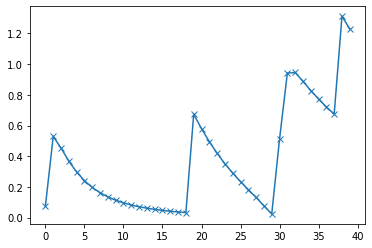

In [45]:
plt.plot(loss, '-x') # without fixed seed + Process

In [46]:
print(F(w0), F(w))

2.1905202447317853 5.462628361680068


In [ ]:
print(f'OUTPUT:\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

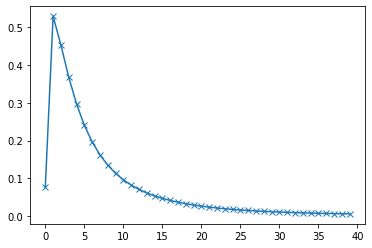

In [17]:
plt.plot(loss, '-x') # with fixed seed in the IRDSA_out (range(1,m)) + Pool

In [15]:
print(F(w0), F(w))

2.1905202447317853 5.410527574118169


In [16]:
print(f'OUTPUT:\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w_pred) = 5.404970175352522

F(w) = 5.410527574118169

w = [-9.75176943e+00  3.69560582e-05  2.07738001e-05 ...  1.27056747e-05
  5.13115687e-07  2.43617941e-05]

average w = [-8.54164542e+00  2.17116842e-04  1.22046075e-04 ...  7.46458388e-05
  3.01455466e-06  1.43125540e-04]

T = 40


In [17]:
%%time
fpred, f, w, mean, t, loss = stochasticZFW(F, d, w0, method = "RDSA", r=10, T=40, eps=1e-3)

Loss evaluation at time 1:	0.0868

Loss evaluation at time 2:	0.7124

Loss evaluation at time 3:	0.5661

Loss evaluation at time 4:	0.5851

Loss evaluation at time 5:	0.2381

Loss evaluation at time 6:	0.2355

Loss evaluation at time 7:	1.6984

Loss evaluation at time 8:	1.5081

Loss evaluation at time 9:	1.2557

Loss evaluation at time 10:	0.6220

Loss evaluation at time 11:	0.5072

Loss evaluation at time 12:	1.0941

Loss evaluation at time 13:	0.9278

Loss evaluation at time 14:	0.9102

Loss evaluation at time 15:	0.5459

Loss evaluation at time 16:	0.2389

Loss evaluation at time 17:	0.1454

Loss evaluation at time 18:	0.0654

Loss evaluation at time 19:	0.1790

Loss evaluation at time 20:	0.0805

Loss evaluation at time 21:	0.3382

Loss evaluation at time 22:	0.0770

Loss evaluation at time 23:	0.0203

Loss evaluation at time 24:	0.0309

Loss evaluation at time 25:	0.0359

Loss evaluation at time 26:	0.0391

Loss evaluation at time 27:	0.0410

Loss evaluation at time 28:	0.0421

L

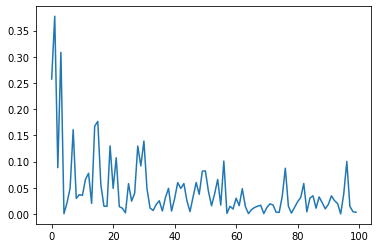

In [4]:
import numpy as np
import matplotlib.pyplot as plt

loss_cox = np.load('../Data/results/loss_SZFW_IRDSA_cox.npy')
plt.plot(loss_cox)
plt.show()

In [5]:
loss_cox

array([2.57475271e-01, 3.77257838e-01, 8.83232584e-02, 3.08421113e-01,
       5.27266767e-04, 2.14881895e-02, 4.92702923e-02, 1.60761101e-01,
       2.97962639e-02, 3.67848683e-02, 3.55033193e-02, 6.61694092e-02,
       7.76986744e-02, 2.02368064e-02, 1.67542104e-01, 1.76617601e-01,
       5.55514267e-02, 1.49123881e-02, 1.44853056e-02, 1.29894924e-01,
       4.88857138e-02, 1.07226293e-01, 1.40213358e-02, 1.09732353e-02,
       2.12429754e-03, 5.78657980e-02, 2.44474355e-02, 3.99791215e-02,
       1.29664660e-01, 9.17045578e-02, 1.39133040e-01, 4.83548157e-02,
       1.14178391e-02, 6.64772664e-03, 1.78797736e-02, 2.52544060e-02,
       5.69452217e-03, 3.11222120e-02, 4.89797343e-02, 5.58472737e-03,
       2.95214404e-02, 5.98512601e-02, 4.87963979e-02, 5.80204119e-02,
       2.49550240e-02, 4.51747836e-03, 3.26727585e-02, 6.00295119e-02,
       3.75754256e-02, 8.16831423e-02, 8.21276038e-02, 4.29698503e-02,
       1.56283743e-02, 3.82045426e-02, 6.59104139e-02, 1.69776081e-02,
      